In [3]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import itertools

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import six
from abc import ABCMeta
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

In [4]:
data_file = './Child_tf.csv'
n = 122676  
s = 122676
skip = sorted(random.sample(range(1,n),n-s))


df = pd.read_csv( data_file, delimiter = ",", skiprows = skip, encoding = 'cp949')
#41만개의 데이터 중 3000개의 데이터만 뽑아서 분석을 진행 

/Users/Moon/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (24,25,28,29,30,32,33,34,35,36,40,43,49,53,54,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.isnull().sum()

개별사건번호                         0
피해아동 대상자ID                     0
학대행위자 대상자ID                    0
아동정보.성별                      306
아동정보.생년월일                  15674
                           ...  
학대조사(대상자관계).아동 관계 구분코드    120247
학대조사(대상자관계).아동 동거 여부.1      1138
학대조사(대상자관계).특별관리유형        116903
판단결과.학대 혐의 여부                  0
판단결과.학대 유형                 76780
Length: 77, dtype: int64

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#이거 꼭 기억하기 개꿀따리임 

In [6]:
a = round(df.isnull().sum() / len(df),5 ) * 100
s = pd.Series(a)
s[s>99]

아동정보.교육기관                 100.000
신고접수.재신고 유형 기타             99.877
신고접수.일반상담 유형               99.999
신고접수.동일신고 여부               99.999
신고접수.동일신고 관리 기관            99.993
신고접수.동일신고이전접수              99.996
신고접수.오인신고 유형               99.994
신고접수.오인신고 사유               99.975
신고접수.특별 관리 유형              99.802
신고접수.오인신고확인기관              99.980
신고접수.행위자수탁명령               99.945
신고접수.행위자수탁명령결정             99.941
신고접수(대상자관계).동일신고관리         99.995
신고접수(대상자관계).재신고유형기타        99.848
신고접수(대상자관계).이전신고여부         99.428
신고접수(대상자관계).동일신고이전         99.995
학대조사(대상자관계).동일신고 이전 사건     99.995
학대조사(대상자관계).보호자 학대 여부     100.000
dtype: float64

In [7]:
df = df.drop(['아동정보.교육기관',
                    '신고접수.신고자유형기타내용',
                    '신고접수.접수 부가확인사항',
                    '신고접수.재신고 유형 기타', 
                    '신고접수.일반상담 유형',
                    '신고접수.동일신고 여부',
                    '신고접수.동일신고 관리 기관',
                    '신고접수.동일신고이전접수',
                    '신고접수.오인신고 유형',
                    '신고접수.오인신고 사유',
                    '신고접수.특별 관리 유형',
                    '신고접수.특별 관리 유형',
                    '신고접수.오인신고확인기관',
                    '신고접수.행위자수탁명령',
                    '신고접수.행위자수탁명령결정',
                    '신고접수(대상자관계).동일신고관리',
                    '신고접수(대상자관계).통계 기관',
                    '신고접수(대상자관계).재신고유형기타',
                    '신고접수(대상자관계).이전신고여부',
                    '신고접수(대상자관계).동일신고이전',
                    '학대조사(대상자관계).동일신고 이전 사건',
                    '학대조사(대상자관계).보호자 학대 여부',
                    '신고접수(대상자관계).통계 기관',
                    '학대조사.현장조사서 순번',
                    '학대조사(대상자관계).아동 관계 구분코드'], axis = 1)

In [8]:
df.columns

Index(['개별사건번호', '피해아동 대상자ID', '학대행위자 대상자ID', '아동정보.성별', '아동정보.생년월일',
       '아동정보.내국인여부', '아동정보.최종 학력', '아동정보.직업 유형', '아동정보.거주상태', '아동정보.친권자 유형',
       '아동정보.가족 유형', '아동정보.다문화가족', '아동정보.가구 소득 구분코드', '아동정보.기초생활수급 유형',
       '신고접수.접수 경로 구분코드', '신고접수.접수 일시', '신고접수.신고자 유형 구분코드', '신고접수.통보 경찰 소속 기관',
       '신고접수.통보 일시', '신고접수.집단 시설내사건 구분', '신고접수.재신고 여부(17년)', '신고접수.재신고 유형',
       '신고접수.재신고이전접수번호', '신고접수.접수 유형', '신고접수.관할지구대', '신고접수.신고접수 구분',
       '신고접수.접수자소속기관명', '신고접수.관할 지역 ID', '신고접수.피해아동 상태 구분', '신고접수.재신고센터ID',
       '신고접수.관할지역기관ID', '신고접수.관리 센터 ID', '신고접수(대상자관계).행위자 아동 관계',
       '신고접수(대상자관계).아동 동거 여부', '신고접수(대상자관계).접수유형', '신고접수(대상자관계).재신고 여부',
       '신고접수(대상자관계).재신고 유형.1', '신고접수(대상자관계).재신고센터ID.1', '신고접수(대상자관계).재신고이전',
       '신고접수(대상자관계).통계 거점', '신고접수(대상자관계).통계 관할지역', '학대조사.집단 시설내사건',
       '학대조사.조사 완료 여부', '학대조사.관할 지역 ID.1', '학대조사.관할 지역 기관 ID',
       '학대조사(대상자관계).재신고 여부.1', '학대조사(대상자관계).재신고 유형 구분코드',
       '학대조사(대상자관계).재신고 관리 기관', '학대조사(대상자관계).재신고 이전 사건',
       '학대조사(대상자관계

In [9]:
df['신고접수.재신고 유형'].unique()

array([nan, '동일센터 사례종결후 재신고', '사례진행중 재신고', '타센터 사례종결후 재신고', '일반상담 후 재신고'],
      dtype=object)

In [10]:
'성별', '거주상태', '가족 유형', '가구 소득 구분코드', '기초생활수급 유형',
       '재신고 유형', '신고접수 구분', '피해아동 상태 구분', '아동 동거 여부', '재신고 여부', '통계 거점',
       '학대 혐의 여부', '생년월일', '재신고 이전 사건 '

IndentationError: unexpected indent (<ipython-input-10-d9e7554ca8f7>, line 2)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [11]:
df['신고접수.접수 일시'].unique()

array(['2018-12-31 ', '2018-12-30 ', '2018-12-29 ', ..., '2014-01-03 ',
       '2014-01-02 ', '2014-01-01 '], dtype=object)

In [81]:
len(df['신고접수.접수 일시'].unique())
#이걸로 14~17까지를 Train, Test를 18로 하기 

1826

In [33]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [7]:
for i in df.columns:
    print(i ,':', df[i].unique())

개별사건번호 : ['5722572220181200160001' '6603660320181200090001'
 '6002600220181200040001' ... '1001100120140100020001'
 '1502150220140100020001' '1502150220140100010001']
피해아동 대상자ID : ['CASRCP20190100282' 'CASRCP20190101182' 'CASRCP20190100497' ...
 'CASRCP20140110878' 'CASRCP20110610831' 'CASRCP20110610830']
학대행위자 대상자ID : ['CASRCP20190100283' 'CASRCP20190101183' 'CASRCP20190100498' ...
 'CASRCP20140220184' 'CASRCP20140121028' 'CASRCP20110620594']
아동정보.성별 : ['M' 'F' 'Z' nan]
아동정보.생년월일 : [20051005. 20041107. 20040218. ... 19960203. 19970127. 19960506.]
아동정보.내국인여부 : ['내국인' nan '외국인' '무국적']
아동정보.최종 학력 : ['재학중' nan '무학' '중등졸업' '고등중퇴' '초등졸업' '중등중퇴' '고등졸업' '초등중퇴' '대학원이상' '대학졸업'
 '대학중퇴']
아동정보.직업 유형 : ['중학교' nan '고등학교' '초등학교' '유치원' '어린이집' '무직' '기타' '기술공 및 준전문가' '전문가' '사무종사자'
 '서비스 및 판매종사자' '관리자' '군인' '단순노무종사자' '장치·기계조작 및 조립 종사자' '농림어업숙련종사자'
 '기능원 및 관련 기능 종사자']
아동정보.거주상태 : ['자택' nan '월세' '기타' '전세' '보증금(전세)+월세' '보호시설' '영구임대아파트  또는 영구임대주택' '무상']
아동정보.친권자 유형 : ['친부모' nan '친부' '친모' '친권자 없음' '양모' '양부모' 

신고접수(대상자관계).재신고센터ID.1 : [nan '시흥아동보호전문기관' '전라남도아동보호전문기관' '경기성남아동보호전문기관' '경기평택아동보호전문기관'
 '안산시아동보호전문기관' '경기남양주아동보호전문기관' '강원남부아동보호전문기관' '강원서부아동보호전문기관'
 '전라북도익산시아동보호전문기관' '제주특별자치도아동보호전문기관' '인천광역시아동보호전문기관' '전라북도남원시아동보호전문기관'
 '경기용인아동보호전문기관' '경북북부아동보호전문기관' '경북동부아동보호전문기관' '충북북부아동보호전문기관'
 '충북남부아동보호전문기관' '인천남부아동보호전문기관' '전남서부권아동보호전문기관' '경기고양아동보호전문기관'
 '서울특별시아동보호전문기관' '수원아동보호전문기관' '경기화성아동보호전문기관' '부산광역시아동보호전문기관'
 '광주광역시아동보호전문기관' '충청남도남부아동보호전문기관' '경기도아동보호전문기관' '경기부천아동보호전문기관'
 '인천북부아동보호전문기관' '전라북도아동보호전문기관' '울산광역시아동보호전문기관' '서울성북아동보호전문기관'
 '울산남부아동보호전문기관' '대구남부아동보호전문기관' '강원도아동보호전문기관' '경상남도아동보호전문기관' '경북남부아동보호전문기관'
 '부산서부아동보호전문기관' '빛고을아동보호전문기관' '전남중부권아동보호전문기관' '서귀포시아동보호전문기관'
 '서울영등포아동보호전문기관' '충청북도아동보호전문기관' '대전광역시아동보호전문기관' '서울특별시동부아동보호전문기관'
 '강원동부아동보호전문기관' '경북서부아동보호전문기관' '경기북부아동보호전문기관' '서울은평아동보호전문기관'
 '서울노원구아동보호전문기관' '충청남도서부아동보호전문기관' '김해시아동보호전문기관' '대구광역시아동보호전문기관'
 '충청남도아동보호전문기관' '서울강서아동보호전문기관' '부산동부아동보호전문기관' '대구북부아동보호전문기관'
 '서울마포아동보호전문기관' '경남서부아동보호전문기관' '아동권리보장원' '서울동남권아동보호전문기관' '부산남부아동보호전문기관']
신고접수(대상자관계)

In [74]:
a = []
for i in df['학대조사(대상자관계).재신고 이전 사건'].isnull():
    if i == True:
        a.append(0)
    else:
        a.append(1)

In [75]:
df = df.drop(['학대조사(대상자관계).재신고 이전 사건'], axis = 1)
df['학대조사(대상자관계).재신고 이전 사건'] = pd.Series(a)
df.head()

,개별사건번호,피해아동 대상자ID,학대행위자 대상자ID,아동정보.성별,아동정보.생년월일,아동정보.내국인여부,아동정보.최종 학력,아동정보.직업 유형,아동정보.거주상태,아동정보.친권자 유형,...,학대조사.관할 지역 기관 ID,학대조사(대상자관계).재신고 여부.1,학대조사(대상자관계).재신고 유형 구분코드,학대조사(대상자관계).재신고 관리 기관,학대조사(대상자관계).동일신고 여부.1,학대조사(대상자관계).아동 동거 여부.1,학대조사(대상자관계).특별관리유형,판단결과.학대 혐의 여부,판단결과.학대 유형,학대조사(대상자관계).재신고 이전 사건
0,5722572220181200160001,CASRCP20190100282,CASRCP20190100283,M,20051005.0,내국인,재학중,중학교,자택,친부모,...,경기용인아동보호전문기관,N,NaN,NaN,N,Y,NaN,Y,양육관련상담,0
1,6603660320181200090001,CASRCP20190101182,CASRCP20190101183,F,20041107.0,NaN,NaN,NaN,NaN,NaN,...,제주특별자치도아동보호전문기관,N,NaN,NaN,N,N,NaN,N,NaN,0
2,6002600220181200040001,CASRCP20190100497,CASRCP20190100498,F,20040218.0,내국인,재학중,중학교,NaN,친부모,...,충청북도아동보호전문기관,N,NaN,NaN,N,Y,NaN,N,NaN,0
3,5202520220181200080001,CASRCP20190301533,CASRCP20190301534,M,20030316.0,내국인,재학중,고등학교,NaN,친부모,...,대구북부아동보호전문기관,N,NaN,NaN,N,Y,NaN,Y,이혼 및 양육권 소송상담,0
4,5601560120181200130001,CASRCP20190100151,CASRCP20190100153,M,20061005.0,내국인,재학중,초등학교,월세,친부모,...,울산광역시아동보호전문기관,N,NaN,NaN,N,N,NaN,Y,NaN,0


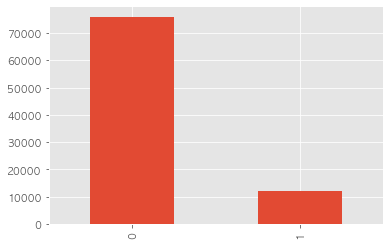

In [76]:
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['학대조사(대상자관계).재신고 이전 사건'].dropna().sort_values(inplace = True)
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['학대조사(대상자관계).재신고 이전 사건'].dropna().value_counts().plot(kind='bar')

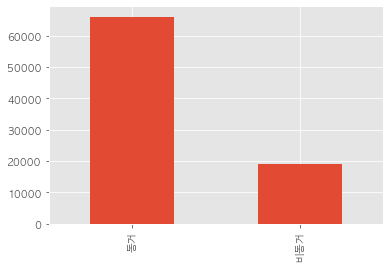

In [73]:
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['신고접수(대상자관계).아동 동거 여부'].dropna().sort_values(inplace = True)
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['신고접수(대상자관계).아동 동거 여부'].dropna().value_counts().plot(kind='bar')

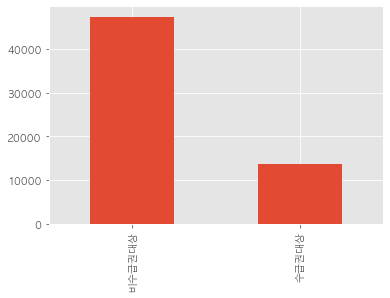

In [71]:
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['아동정보.기초생활수급 유형'].dropna().sort_values(inplace = True)
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['아동정보.기초생활수급 유형'].dropna().value_counts().plot(kind='bar')

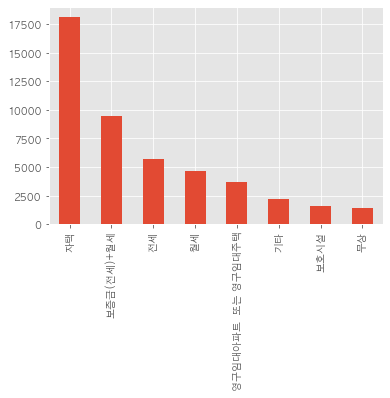

In [69]:
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['아동정보.거주상태'].dropna()
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['아동정보.거주상태'].dropna().sort_values(inplace = True)
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['아동정보.거주상태'].dropna().value_counts().plot(kind='bar')

In [49]:
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['학대조사(대상자관계).재신고 유형 구분코드'].dropna()

58        동일센터 사례종결후 재신고
66        동일센터 사례종결후 재신고
69             사례진행중 재신고
87             사례진행중 재신고
102            사례진행중 재신고
               ...      
122656    동일센터 사례종결후 재신고
122668         사례진행중 재신고
122671    동일센터 사례종결후 재신고
122674        일반상담 후 재신고
122675        일반상담 후 재신고
Name: 학대조사(대상자관계).재신고 유형 구분코드, Length: 12138, dtype: object

In [54]:
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['아동정보.가구 소득 구분코드'].dropna()

5         150만원이상-200만원미만
6                 300만원이상
8                 300만원이상
12        250만원이상-300만원미만
28        200만원이상-250만원미만
               ...       
122657    100만원이상-150만원미만
122658    100만원이상-150만원미만
122660    200만원이상-250만원미만
122662    100만원이상-150만원미만
122674    200만원이상-250만원미만
Name: 아동정보.가구 소득 구분코드, Length: 38967, dtype: object

In [50]:
df.loc[df['판단결과.학대 혐의 여부'] =='Y']['학대조사(대상자관계).재신고 이전 사건'].dropna()

58        8.112016e+12
66        1.102202e+13
69        5.206202e+13
87        5.715202e+13
102       5.603202e+13
              ...     
122656    1.001201e+13
122668    8.012013e+12
122671    1.201201e+13
122674    1.502201e+13
122675    1.502201e+13
Name: 학대조사(대상자관계).재신고 이전 사건, Length: 12062, dtype: float64

In [ ]:
#재신고이전사건, 학대 혐의 여부

In [21]:
df.isnull().sum()
#교육기관, 최종학력, 직업유형, 거주상태, 가구 소득 구분 코드, 기초생활 수급 유형, 통보 경찰 소속 기관, 일반상담 유형, 동일신고 여부, 동일신고 관리 기관, 동일신고이전접수, 오인신고 유형, 오인시고 사유, 특별 관리 유형, 관할지구대, 오인신고확인기관, 행위자수탁명령 ,행위자수탁명령결정, 피해아동 상태 구분, 재신고센터ID, 동일신고관리, 재신고유형.1, 재신고센터ID.1, 재신고유형기타, 이전신고여부, 동일신고이전, 재신고이전, 집단 시설내사건, 재신고 유형 구분코드, 재신고 관리 기관, 재신고 이전 사건, 동일신고 이전 사건, 보호자 학대 여부, 아동 관계 구분코드, 특별관리유형, 학대유형 

개별사건번호                          0
피해아동 대상자ID                      0
학대행위자 대상자ID                     0
아동정보.성별                       306
아동정보.생년월일                   15674
아동정보.내국인여부                  16292
아동정보.최종 학력                  75520
아동정보.직업 유형                  77099
아동정보.거주상태                   62605
아동정보.친권자 유형                  9489
아동정보.가족 유형                  10000
아동정보.다문화가족                  21040
아동정보.가구 소득 구분코드             73118
아동정보.기초생활수급 유형              43621
신고접수.접수 경로 구분코드                 0
신고접수.접수 일시                      0
신고접수.신고자 유형 구분코드                0
신고접수.통보 경찰 소속 기관            66993
신고접수.통보 일시                  35507
신고접수.집단 시설내사건 구분            58320
신고접수.재신고 여부(17년)            40241
신고접수.재신고 유형                112516
신고접수.재신고이전접수번호             112532
신고접수.접수 유형                      0
신고접수.관할지구대                  97957
신고접수.신고접수 구분                    0
신고접수.접수자소속기관명                   0
신고접수.관할 지역 ID                 341
신고접수.피해아동 상태 구분             83094
신고접수.재신고센터ID  

In [9]:
df.isnull().sum()
#이렇게 50%가 넘는 컬럼을 제거하고 결측치를 제거하면 최종적으로 8개의 Row만 남음 

개별사건번호              0
피해아동 대상자ID          0
학대행위자 대상자ID         0
성별                306
생년월일            15674
내국인여부           16292
교육기관           122676
최종 학력           75520
직업 유형           77099
거주상태            62605
친권자 유형           9489
가족 유형           10000
다문화가족           21040
가구 소득 구분코드      73118
기초생활수급 유형       43621
접수 경로 구분코드          0
접수 일시               0
신고자 유형 구분코드         0
신고자유형기타내용       51473
통보 경찰 소속 기관     66993
통보 일시           35507
접수 부가확인사항       58320
집단 시설내사건 구분     58320
재신고 여부(17년)     40241
재신고 유형         112516
재신고 유형 기타      122525
재신고이전접수번호      112532
접수 유형               0
일반상담 유형        122675
동일신고 여부        122675
동일신고 관리 기관     122667
동일신고이전접수       122671
오인신고 유형        122669
오인신고 사유        122645
특별 관리 유형       122433
관할지구대           97957
오인신고확인기관       122652
신고접수 구분             0
접수자소속기관명            0
관할 지역 ID          341
행위자수탁명령        122609
행위자수탁명령결정      122604
피해아동 상태 구분      83094
재신고센터ID        112400
관할지역기관ID          170
관리 센터 ID  

In [10]:
for i in df.columns:
    print(i ,':', df[i].unique())

개별사건번호 : ['5722572220181200160001' '6603660320181200090001'
 '6002600220181200040001' ... '1001100120140100020001'
 '1502150220140100020001' '1502150220140100010001']
피해아동 대상자ID : ['CASRCP20190100282' 'CASRCP20190101182' 'CASRCP20190100497' ...
 'CASRCP20140110878' 'CASRCP20110610831' 'CASRCP20110610830']
학대행위자 대상자ID : ['CASRCP20190100283' 'CASRCP20190101183' 'CASRCP20190100498' ...
 'CASRCP20140220184' 'CASRCP20140121028' 'CASRCP20110620594']
성별 : ['M' 'F' 'Z' nan]
생년월일 : [20051005. 20041107. 20040218. ... 19960203. 19970127. 19960506.]
내국인여부 : ['내국인' nan '외국인' '무국적']
교육기관 : [nan]
최종 학력 : ['재학중' nan '무학' '중등졸업' '고등중퇴' '초등졸업' '중등중퇴' '고등졸업' '초등중퇴' '대학원이상' '대학졸업'
 '대학중퇴']
직업 유형 : ['중학교' nan '고등학교' '초등학교' '유치원' '어린이집' '무직' '기타' '기술공 및 준전문가' '전문가' '사무종사자'
 '서비스 및 판매종사자' '관리자' '군인' '단순노무종사자' '장치·기계조작 및 조립 종사자' '농림어업숙련종사자'
 '기능원 및 관련 기능 종사자']
거주상태 : ['자택' nan '월세' '기타' '전세' '보증금(전세)+월세' '보호시설' '영구임대아파트  또는 영구임대주택' '무상']
친권자 유형 : ['친부모' nan '친부' '친모' '친권자 없음' '양모' '양부모' '후견인 없음' '양부']
가족 유형 :

관할 지역 ID.1 : ['수지구' '제주시' '서원구' '북구' '경산시' '원미구' '태백시' '단원구' '서구' '해운대구' '성북구' '시흥시'
 '부평구' '여수시' '서초구' '미추홀구' '강릉시' '과천시' '광주시' '군산시' '영광군' '영덕군' '서북구'
 '마산합포구' '부산진구' '달서구' '수영구' '정읍시' '충주시' '안성시' '분당구' '도봉구' '평택시' '덕진구'
 '은평구' '화성시' '공주시' '수성구' '중구' '계양구' '구미시' '순천시' '양주시' '울주군' '칠곡군' '동구'
 '동안구' '처인구' '동남구' '속초시' '논산시' '무주군' '남양주시' '장안구' '남구' '구리시' '예천군' '유성구'
 '완산구' '원주시' '남동구' '익산시' '화순군' '김포시' '용산구' '진주시' '동작구' '제천시' '영등포구' '금정구'
 '일산서구' '광명시' '남원시' '광산구' '강북구' '상당구' '목포시' '동해시' '양산시' '덕양구' '강서구' '장수군'
 '아산시' '동대문구' '문경시' '음성군' '부안군' '삼척시' '군포시' '춘천시' '거제시' '김해시' '구로구' '거창군'
 '일산동구' '수정구' '서산시' '양구군' '안동시' '성동구' '상록구' '이천시' '영통구' '진도군' '당진시'
 '세종특별자치시' '영동군' '성산구' '연수구' '양천구' '강동구' '의왕시' '금천구' '김천시' '고흥군' '대덕구'
 '노원구' '권선구' '팔달구' '동래구' '강남구' '사천시' '서귀포시' '연제구' '오산시' '보령시' '기장군' '금산군'
 '만안구' '완주군' '나주시' '군위군' '광진구' '파주시' '홍천군' '양양군' '장흥군' '사하구' '상주시' '마포구'
 '중랑구' '예산군' '동두천시' '영월군' '해남군' '광양시' '여주시' '흥덕구' '청원구' '의창구' '의정부시' '경주시'
 '영주시' '포천시' '서대문구' '단양군' '강진군' '홍성군' '전주시' '밀양시' 

이혼 및 양육권 소송상담      17895
양육관련상담             12843
성인이 아닌 자에 의한 학대    12275
시설입소상담              2883
Name: 학대 유형, dtype: int64


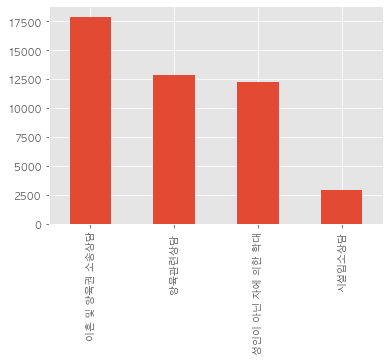

In [11]:
df['학대 유형'].value_counts().plot(kind='bar')
print(df['학대 유형'].value_counts())

Y    87960
N    34716
Name: 학대 혐의 여부, dtype: int64


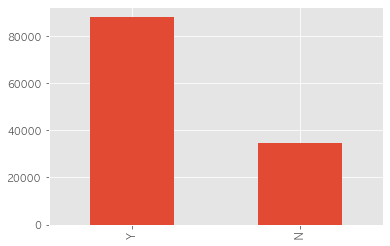

In [12]:
df['학대 혐의 여부'].value_counts().plot(kind='bar')
print(df['학대 혐의 여부'].value_counts())

N    107000
Y     15676
Name: 재신고 여부.1, dtype: int64


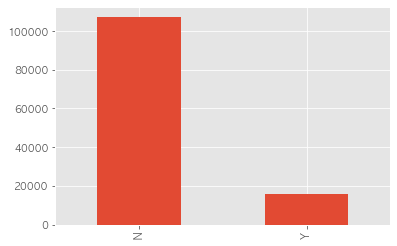

In [13]:
df['재신고 여부.1'].value_counts().plot(kind='bar')
print(df['재신고 여부.1'].value_counts())

Y    120082
N      2594
Name: 조사 완료 여부, dtype: int64


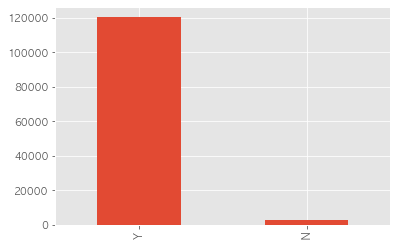

In [14]:
df['조사 완료 여부'].value_counts().plot(kind='bar')
print(df['조사 완료 여부'].value_counts())

N    702
Name: 이전신고여부, dtype: int64


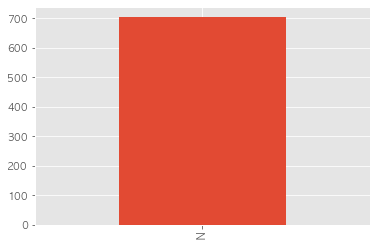

In [15]:
df['이전신고여부'].value_counts().plot(kind='bar')
print(df['이전신고여부'].value_counts())

동거     86472
비동거    31316
Name: 아동 동거 여부, dtype: int64


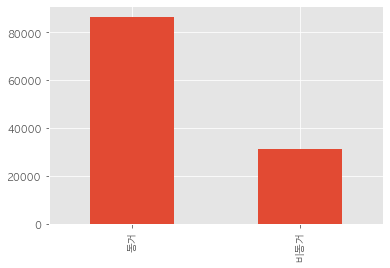

In [17]:
df['아동 동거 여부'].value_counts().plot(kind='bar')
print(df['아동 동거 여부'].value_counts())

친부                            48431
친모                            35937
어린이집(보육교직원, 종사자)               7397
학교(교원, 교직원)                    6158
아동복지시설종사자                      3008
유치원(교사,교직원, 종사자)               2361
기타                             2348
계부                             2042
친인척                            1985
계모                             1871
친조모                            1417
학원(강사, 종사자)                    1143
부모의 동거인                        1024
형제자매                            925
낯선사람                            895
친조부                             842
외조모                             673
이웃                              651
기타시설종사자                         386
외조부                             331
양부                              162
양모                              128
청소년관련시설종사자                      116
베이비시터(아이돌보미)                    105
위탁모                              60
위탁부                              28
아동을 보호ㆍ양육ㆍ교육하거나 그 의무가 있는 자        1
Name: 행위자 아동 관계, dtype: int6

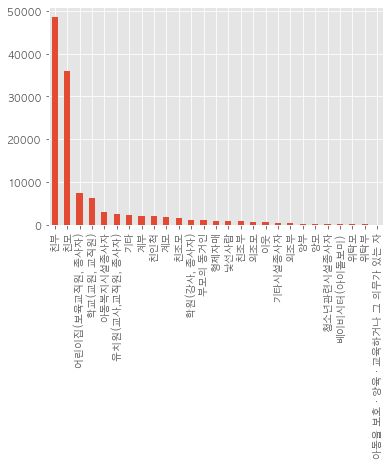

In [18]:
df['행위자 아동 관계'].value_counts().plot(kind='bar')
print(df['행위자 아동 관계'].value_counts())

해당사항없음          39530
아동사망               35
중상해(의식불명 포함)       17
Name: 피해아동 상태 구분, dtype: int64


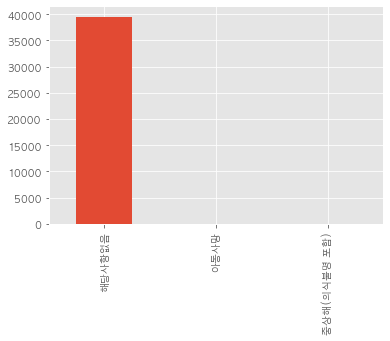

In [20]:
df['피해아동 상태 구분'].value_counts().plot(kind='bar')
print(df['피해아동 상태 구분'].value_counts())

서구         4186
북구         3912
남구         3630
단원구        2464
동구         2278
상록구        2258
중구         2202
목포시        1585
제주시        1563
익산시        1517
남양주시       1496
달서구        1485
구미시        1396
화성시        1356
완산구        1337
남동구        1313
의정부시       1292
미추홀구       1255
부평구        1254
원주시        1250
시흥시        1228
군산시        1192
평택시        1133
강서구        1116
김해시        1115
은평구        1083
덕진구        1045
남원시         992
서귀포시        964
부산진구        962
서북구         927
해운대구        922
안동시         916
춘천시         895
노원구         887
광산구         876
진주시         870
순천시         857
계양구         846
도봉구         834
여수시         818
양천구         807
중랑구         806
권선구         806
충주시         786
연수구         765
수정구         760
강릉시         759
아산시         752
구로구         751
제천시         744
광명시         742
성북구         727
원미구         726
흥덕구         725
수성구         720
덕양구         710
광주시         702
동래구         690
장안구         686
오산시         684
거제시         680
수지구     

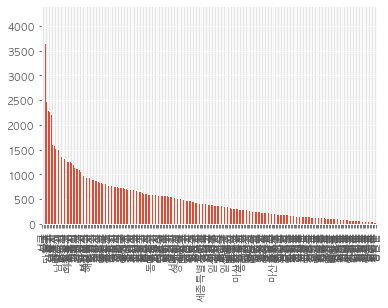

In [21]:
df['관할 지역 ID'].value_counts().plot(kind='bar')
print(df['관할 지역 ID'].value_counts())

안산                 2161
경남                 1965
울산                 1927
전북서부               1773
전북                 1746
서울동부               1669
경기                 1627
경기성남               1559
안산시아동보호전문기관        1539
경기북부               1513
충북                 1500
인천                 1494
충남                 1423
경기화성               1378
부산광역시아동보호전문기관      1360
경북동부               1342
대전                 1281
경기용인               1280
부산동부               1267
전라북도서부아동보호전문기관     1240
전라북도아동보호전문기관       1209
전남                 1206
전남서부권              1168
경기부천               1153
경북동부아동보호전문기관       1119
수원아동보호전문기관         1093
전남서부권아동보호전문기관      1088
경기고양               1082
전라남도아동보호전문기관       1080
광주                 1063
전남중부권              1050
경기북부아동보호전문기관       1038
서울                 1025
경상남도아동보호전문기관       1021
서울영등포              1018
경북서부아동보호전문기관       1016
부산                 1015
인천북부아동보호전문기관        992
서울은평                991
경기남양주               963
대구남부아동보호전문기관        952
대구              

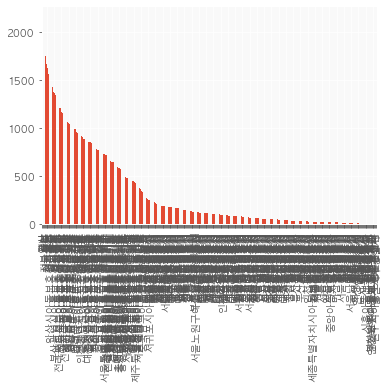

In [22]:
df['접수자소속기관명'].value_counts().plot(kind='bar')
print(df['접수자소속기관명'].value_counts())

아동보호전문기관접수    84382
경찰접수          38294
Name: 신고접수 구분, dtype: int64


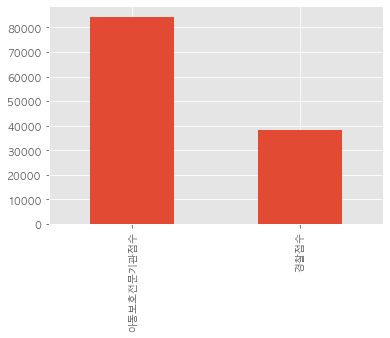

In [23]:
df['신고접수 구분'].value_counts().plot(kind='bar')
print(df['신고접수 구분'].value_counts())

공동모금회사업          242
가족재결합 평가도구 사용      1
Name: 특별 관리 유형, dtype: int64


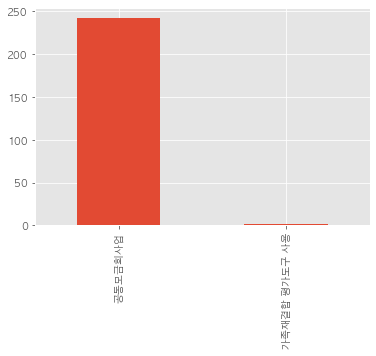

In [24]:
df['특별 관리 유형'].value_counts().plot(kind='bar')
print(df['특별 관리 유형'].value_counts())

Y    1
Name: 동일신고 여부, dtype: int64


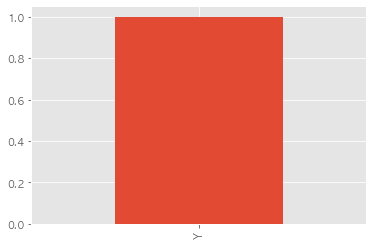

In [25]:
df['동일신고 여부'].value_counts().plot(kind='bar')
print(df['동일신고 여부'].value_counts())

아동학대 의심사례                        122601
학대행위자 법원명령을 통한 인지(임시조치, 보호처분)        73
피해아동보호명령을 통한 인지                       1
일반상담                                  1
Name: 접수 유형, dtype: int64


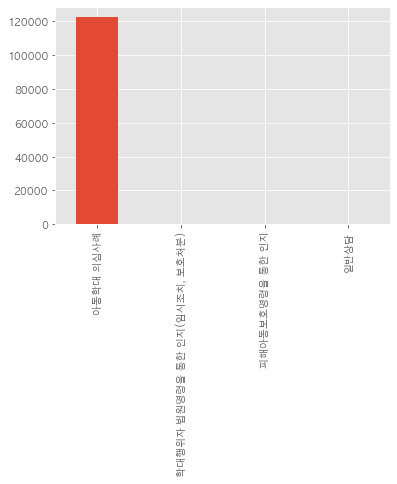

In [26]:
df['접수 유형'].value_counts().plot(kind='bar')
print(df['접수 유형'].value_counts())

없음    72276
있음    10159
Name: 재신고 여부(17년), dtype: int64


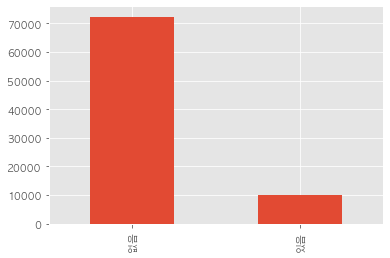

In [27]:
df['재신고 여부(17년)'].value_counts().plot(kind='bar')
print(df['재신고 여부(17년)'].value_counts())

해당사항없음    59206
교육기관       2798
어린이집       1297
시설          882
기타          173
Name: 집단 시설내사건 구분, dtype: int64


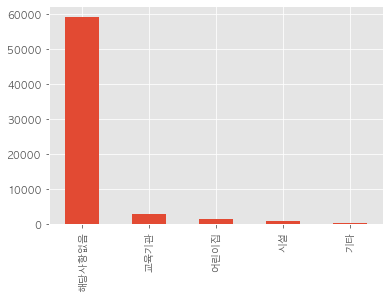

In [28]:
df['집단 시설내사건 구분'].value_counts().plot(kind='bar')
print(df['집단 시설내사건 구분'].value_counts())

해당사항없음    63479
언론노출        877
Name: 접수 부가확인사항, dtype: int64


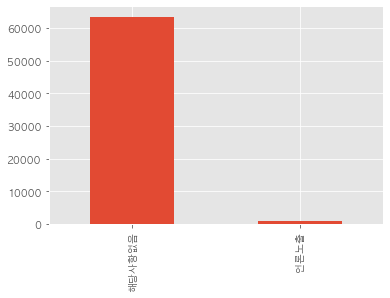

In [29]:
df['접수 부가확인사항'].value_counts().plot(kind='bar')
print(df['접수 부가확인사항'].value_counts())

부모                                21228
교직원, 전문상담교사, 산학겸임교사               19819
아동보호전문기관장과종사자                     15415
아동본인                              12912
사회복지관련종사자                         11783
이웃,친구                              7952
경찰                                 5531
사회복지전담공무원                          3604
기타                                 3471
친인척                                3006
낯선사람                               2294
아동복지시설종사자                          1859
형제,자매                              1455
보육교직원                              1399
취약계층아동 통합서비스 지원인력                  1233
가정폭력상담소보호시설종사자                     1225
청소년시설,단체종사자                        1188
사회복지시설종사자                          1162
의료인, 의료기사                          1109
익명                                  974
아동보호전문기관상담원                         685
성폭력피해자통합지원센터종사자, 성폭력피해자보호시설종사자      456
유치원교직원,강사                           453
아동복지전담공무원                           355
청소년보호센터,청소년재활센터종사자                  283


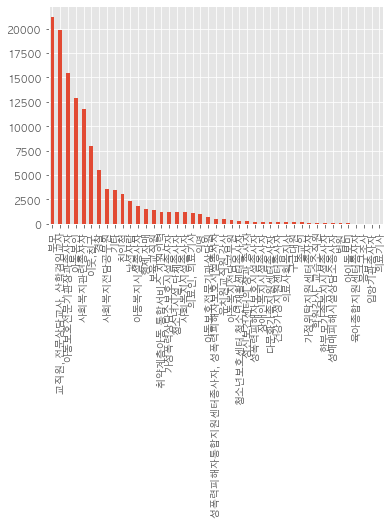

In [30]:
df['신고자 유형 구분코드'].value_counts().plot(kind='bar')
print(df['신고자 유형 구분코드'].value_counts())

재학중      43022
무학        2425
고등중퇴       616
중등졸업       371
초등졸업       360
중등중퇴       174
고등졸업       115
대학원이상       33
초등중퇴        32
대학졸업         7
대학중퇴         1
Name: 최종 학력, dtype: int64


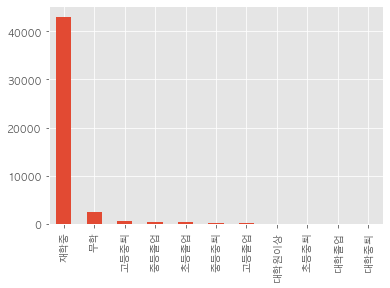

In [31]:
df['최종 학력'].value_counts().plot(kind='bar')
print(df['최종 학력'].value_counts())

내국인    105693
외국인       685
무국적         6
Name: 내국인여부, dtype: int64


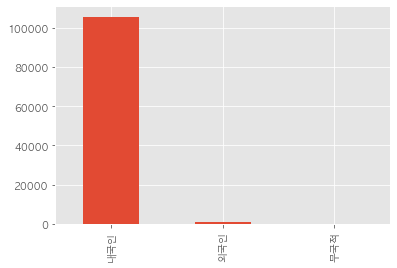

In [32]:
df['내국인여부'].value_counts().plot(kind='bar')
print(df['내국인여부'].value_counts())

### EDA

자택                    23447
보증금(전세)+월세            11631
전세                     7516
월세                     5726
영구임대아파트  또는 영구임대주택     4639
기타                     2880
보호시설                   2416
무상                     1816
Name: 거주상태, dtype: int64


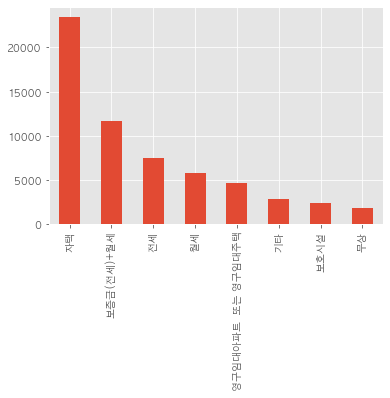

In [33]:
df['거주상태'].value_counts().plot(kind='bar')
print(df['거주상태'].value_counts())

300만원이상            13693
150만원이상-200만원미만     7380
100만원이상-150만원미만     7204
200만원이상-250만원미만     6830
50만원이상~100만원미만      5439
250만원이상-300만원미만     4772
50만원미만              4240
Name: 가구 소득 구분코드, dtype: int64


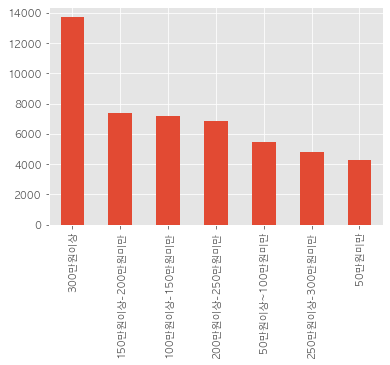

In [34]:
df['가구 소득 구분코드'].value_counts().plot(kind='bar')
print(df['가구 소득 구분코드'].value_counts())

비수급권대상    61683
수급권대상     17372
Name: 기초생활수급 유형, dtype: int64


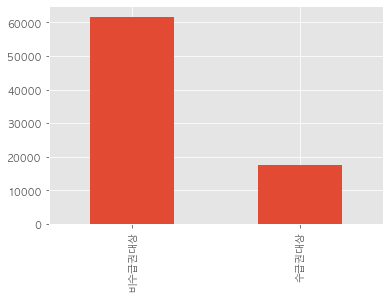

In [35]:
df['기초생활수급 유형'].value_counts().plot(kind='bar')
print(df['기초생활수급 유형'].value_counts())
#오호?(지정한 가정이 잘못되었음 )

친부모가정        64011
부자가족(이혼)     11682
모자가족(이혼)     10418
재혼가정          7142
동거(사실혼포함)     2915
친인척보호         2701
모자가족(별거)      2487
시설보호          2075
미혼부·모가정       2052
부자가족(별거)      1749
모자가족(사별)      1457
부자가족(가출)      1354
부자가족(사별)       959
기타             605
입양가정           379
모자가족(가출)       379
위탁가정           210
소년소녀가정         101
Name: 가족 유형, dtype: int64


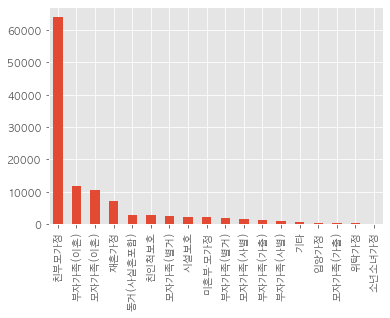

In [36]:
df['가족 유형'].value_counts().plot(kind='bar')
print(df['가족 유형'].value_counts())

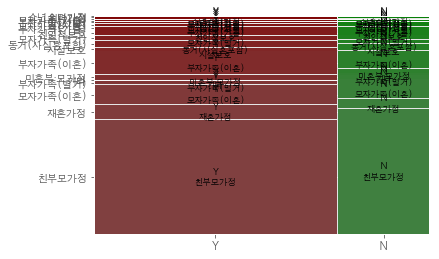

In [37]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
mosaic(df, ['학대 혐의 여부', '가족 유형']);

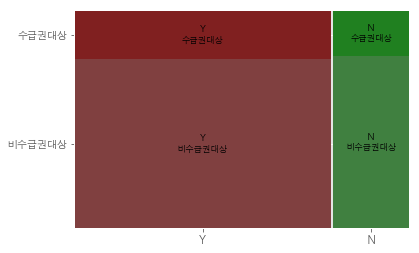

In [38]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
mosaic(df, ['학대 혐의 여부', '기초생활수급 유형']);

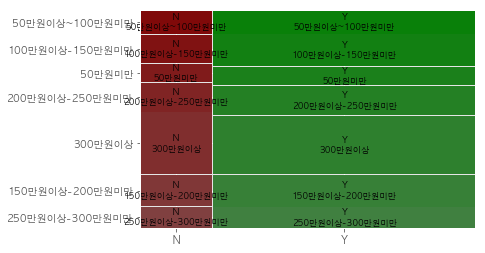

In [39]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
mosaic(df, ['학대 혐의 여부', '가구 소득 구분코드']);

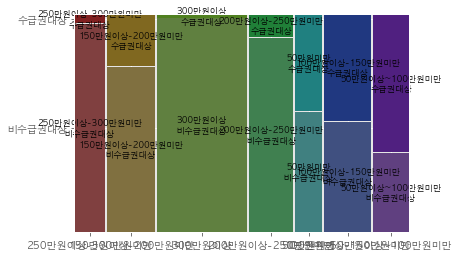

In [40]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
mosaic(df, ['가구 소득 구분코드', '기초생활수급 유형']);

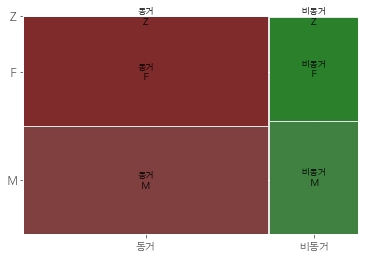

In [41]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
mosaic(df, ['아동 동거 여부', '성별']);

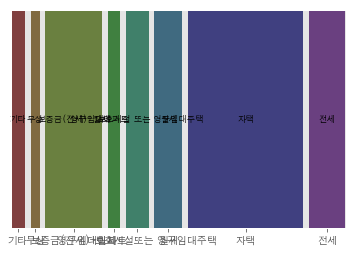

In [42]:
mosaic(df.sort_values('거주상태'), ['거주상태'], gap=0.02 )

plt.show()

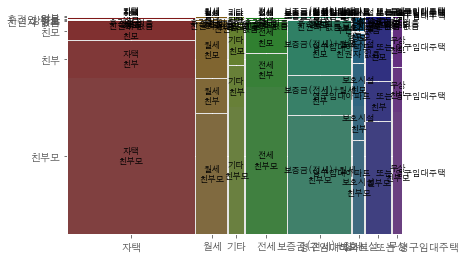

In [43]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
mosaic(df, ['거주상태', '친권자 유형']);

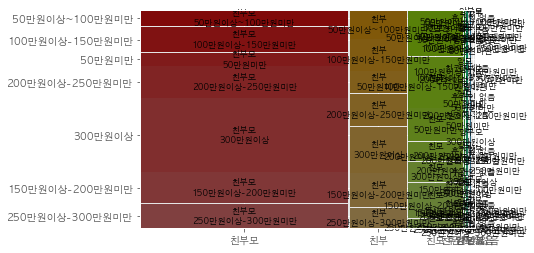

In [44]:

plt.rcParams['font.size'] = 10.0
mosaic(df, ['친권자 유형', '가구 소득 구분코드']);